<a href="https://colab.research.google.com/github/rachelburton/TradeSpace/blob/main/OS4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OS4 - Model

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools
import scipy.optimize as opt
import os
import math #rachel needs for round down function in wait time calcs
import plotly.express as px
import plotly.graph_objects as go

## Task 1

**Assumptions**
- Passenger throughput and passenger volume are for a specific route or region
- The utility values stay between 0 and 1
- Any attribute that exceeds the range for the utility function will have the utility value at the end of the range

### Define Functions

In [ ]:
# This will probably need to be updated based on how we want to organize our attribute utilities.
# I just figured I would get the equation for a multi-attribute utility fn in here

def utility_fn( attribute_dict, passenger_throughput, availability, passenger_vol, avg_wait_time):
  """
  Calculate the multi-attribute utility function.
  total_utility = np.dot(utility_attributes, utility_weights)

  Args:
    attribute_dict: Dictionary - A dictionary containing the equation and weight for each attribute.
    passenger_throughput: Float - The passenger throughput value [passenger trips/hr]
    availability: Float - The availability value [dml^4]
    passenger_vol: Float - The passenger volume value [passenger trips/day]
    avg_wait_time: Float - The average wait time value [minutes]

  Returns:
    results: Dictionary - A dictionary containing the original values for each attribute,
             utility values for each attribute, and the total utility.
  """
  # Calculate utilities
  # Grab the utility equation from the attribute dictionary and calculate the utilty value for the specified input
  pass_throughput_utility = attribute_dict['Passenger Throughput']['Equation'](passenger_throughput)
  availability_utility = attribute_dict['Availability']['Equation'](availability)
  pass_volume_utility = attribute_dict['Passenger Volume']['Equation'](passenger_vol)
  avg_wait_time_utility = attribute_dict['Average Wait Time']['Equation'](avg_wait_time)

  # Create a list of all the utility values
  utility_values = [pass_throughput_utility, availability_utility, pass_volume_utility, avg_wait_time_utility]

  # Create a list of the utility weights from the attribute dictionary
  # It is very important that the order of this list is the same as the utility value list
  utility_weights = [attribute_dict['Passenger Throughput']['Weight'],
                     attribute_dict['Availability']['Weight'],
                     attribute_dict['Passenger Volume']['Weight'],
                     attribute_dict['Average Wait Time']['Weight']]

  # Calculate the total utility as the sum of the product of each utility/weight pair
  total_utility = np.dot(utility_values, utility_weights)

  # Return a dictionary of all values and utilities
  results = {
    'Passenger Throughput': passenger_throughput,
    'Availability': availability,
    'Passenger Volume': passenger_vol,
    'Average Wait Time': avg_wait_time,
    'Passenger Throughput Utility': pass_throughput_utility,
    'Availability Utility': availability_utility,
    'Passenger Volume Utility': pass_volume_utility,
    'Average Wait Time Utility': avg_wait_time_utility,
    'Total Utility': total_utility
  }
  return results

In [ ]:
def capped_polynomial(x, coefficients, threshold, cap_value):
    # Evaluate the polynomial
    eq = np.poly1d(coefficients)
    poly_val = eq(x)
    # Apply the cap
    return np.where(x >= threshold, cap_value, poly_val)

### Import Data

In [ ]:
# NOTE - Make sure you download the latest SAU_input_multiples file from the Drive and upload it here.

# Load the Excel file
file_name = 'SAU_input_multiples.xlsx'

# Access the sheet
workbook = pd.ExcelFile(file_name)

# Create an empty dataframe to hold the attribute utility data
utility_df = pd.DataFrame()

#Create an empty dataframe to hold the weight data
weights_df = pd.DataFrame()

# Iterate through each sheet
for sheet_name in workbook.sheet_names:
  # Read data into a pandas DataFrame
  temp =  pd.read_excel(file_name, sheet_name=sheet_name, header=0)
  if sheet_name == 'Weights':
    # Set the weight dataframe equal to the contents of the weights sheet
     weights_df = temp
  else:
    # Add a column with the attribute name (aka the name of the sheet in the excel file)
    temp.insert(0, 'Attribute', sheet_name)

    # Append the temp df to the end of our utility df
    utility_df = pd.concat([utility_df, temp])

In [ ]:
# Look at the first 7 rows in the dataframe
utility_df.head(100)

Attribute   Value  Utility
0  Passenger Throughput     0.0     0.00
1  Passenger Throughput    50.0     0.20
2  Passenger Throughput   100.0     0.50
3  Passenger Throughput   150.0     0.90
4  Passenger Throughput   200.0     1.00
0          Availability     0.0     0.00
1          Availability     0.2     0.20
2          Availability     0.4     0.40
3          Availability     0.6     0.60
4          Availability     0.8     0.80
5          Availability     1.0     1.00
0      Passenger Volume     0.0     0.00
1      Passenger Volume   500.0     0.20
2      Passenger Volume  1000.0     0.40
3      Passenger Volume  1500.0     0.80
4      Passenger Volume  2000.0     1.00
0     Average Wait Time     0.0     1.00
1     Average Wait Time     5.0     0.95
2     Average Wait Time    10.0     0.75
3     Average Wait Time    15.0     0.40
4     Average Wait Time    20.0     0.20
5     Average Wait Time    30.0     0.00

In [ ]:
# Set the index to the attribute column to easily access the weight by attribute name
weights_df.set_index('Attribute', inplace=True)
weights_df

Weight
Attribute                   
Passenger Volume        0.15
Passenger Throughput    0.25
Average Wait Time       0.35
Availability            0.25

### Calculate best fit lines

#### Set up data structure for storage

In [ ]:
# Get a list of all the unique attributes in our utility dataframe
attributes = utility_df.Attribute.unique()
print(attributes)


['Passenger Throughput' 'Availability' 'Passenger Volume'
 'Average Wait Time']


In [ ]:
# Create an empty dictionary that we will add to as we
# calculate the lines of best fit
attribute_dict = {}

# Add the weights for each attribute to the dictionary
for attribute in attributes:
  attribute_dict[attribute] = {"Weight": None, "Equation Type": None, "Equation": None}
  attribute_dict[attribute]["Weight"] = weights_df.loc[attribute, 'Weight']

attribute_dict


{'Passenger Throughput': {'Weight': 0.25,
  'Equation Type': None,
  'Equation': None},
 'Availability': {'Weight': 0.25, 'Equation Type': None, 'Equation': None},
 'Passenger Volume': {'Weight': 0.15, 'Equation Type': None, 'Equation': None},
 'Average Wait Time': {'Weight': 0.35,
  'Equation Type': None,
  'Equation': None}}

#### Generate the equations for the line of best fit

In [ ]:
# Loop through all the unique values in the attribute column
for attribute in attributes:
  # Create a temporary dataframe with only the values for that attribute
  temp_df = utility_df[utility_df['Attribute'] == attribute]

  # Set up a temp best fit dictionary to hold best fit values
  temp_best_fit = {"Poly_val": 0,
                   "RMSE": 100000000000,
                   "equation": None}
  # Calculate the best fit line for the attribute
  # Loop through 1st order and 2nd order polynomials
  for poly in [1, 2, 3, 4]:
    # Calculate the polynomial
    try:
      coefficients = np.polyfit(temp_df['Value'], temp_df['Utility'], poly)
    except np.RankWarning:
      continue
    equation = np.poly1d(coefficients)
    # Calculate the y values from the polynomial
    y_predicted = equation(temp_df['Value'])

    # Get the residuals
    residuals = temp_df['Utility'] - y_predicted

    # Calculate the root mean squared error (RMSE) for the polynomial
    # Our goal is to minimize the RMSE
    rmse = np.sqrt(np.mean(residuals ** 2))

    # If the polynomial has a better RMSE than what is saved, update the temp dictionary
    if rmse < temp_best_fit['RMSE']:
      temp_best_fit['Poly_val'] = poly
      temp_best_fit['RMSE'] = rmse
      temp_best_fit['Equation'] = lambda x, coeffs=coefficients, thresh=list(temp_df['Value'])[-1], cap=list(temp_df['Utility'])[-1]: capped_polynomial(x, coeffs, thresh, cap)

    # Add the equation to the attribute dictionary
    attribute_dict[attribute]["Equation"] = temp_best_fit['Equation']

### Plot the data

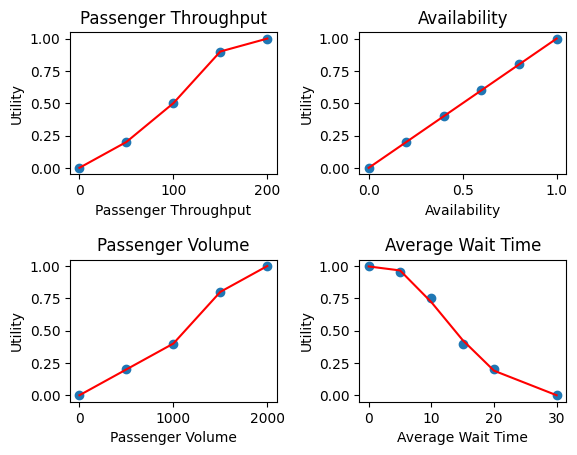

In [ ]:
# Create a figure that holds four plots - 2 rows and 2 columns
fig, axs = plt.subplots(2, 2)

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Loop through the attributes in the attribute list
# Get the attribute and the index of the attribute in the list (0, 1, 2, 3)
for index, attribute in enumerate(attributes):

  # Create a temporary dataframe with only the values for that attribute
  temp_df = utility_df[utility_df['Attribute'] == attribute]

  # Plot the values as a scatter plot
  axs[index // 2, index % 2].scatter(temp_df['Value'], temp_df['Utility'])
  plt.sca(axs[index // 2, index % 2])
  plt.xlabel(attribute)
  plt.ylabel('Utility')
  plt.title(attribute)

  # Plot the line of best fit
  axs[index // 2, index % 2].plot(temp_df['Value'], attribute_dict[attribute]['Equation'](temp_df['Value']), color='red')
  # Add the equation to the plot
  # plt.text(0.5, 0.5, equation, color="red", fontsize=8,
  #        horizontalalignment='left', verticalalignment='center',
  #        transform=plt.gca().transAxes)

plt.show()

### Calculate the multi-attribute utility

In [ ]:
# Create an empty dictionary to hold the results of the MAU calculations
results_df = pd.DataFrame()

In [ ]:
# Calculate the MAU fopr Case A (as defined in the assignment)
case_A_MAU = utility_fn(attribute_dict, passenger_throughput=75, availability=0.7, passenger_vol=1000, avg_wait_time=8)
results_df = pd.concat([results_df, pd.DataFrame(case_A_MAU, index=[0])], ignore_index=True)

# Calculate the MAU fopr Case B (as defined in the assignment)
case_B_MAU = utility_fn(attribute_dict, passenger_throughput=100, availability=0.6, passenger_vol=2000, avg_wait_time=12)
results_df = pd.concat([results_df, pd.DataFrame(case_B_MAU, index=[0])], ignore_index=True)

# Calculate the MAU fopr Case C (as defined in the assignment)
case_C_MAU = utility_fn(attribute_dict, passenger_throughput=75, availability=0.8, passenger_vol=750, avg_wait_time=6)
results_df = pd.concat([results_df, pd.DataFrame(case_C_MAU, index=[0])], ignore_index=True)

results_df

Passenger Throughput  Availability  Passenger Volume  Average Wait Time  \
0                    75           0.7              1000                  8   
1                   100           0.6              2000                 12   
2                    75           0.8               750                  6   

   Passenger Throughput Utility  Availability Utility  \
0                      0.328125                   0.7   
1                      0.500000                   0.6   
2                      0.328125                   0.8   

   Passenger Volume Utility  Average Wait Time Utility  Total Utility  
0                  0.400000                   0.832192       0.608298  
1                  1.000000                   0.601191       0.635417  
2                  0.273438                   0.927721       0.647749

## Task 2

### Define Functions

#### General Functions

In [ ]:
def cross_join(df1, df2):
    """
    Performs a cross join between two DataFrames.

    Args:
        df1: The first DataFrame.
        df2: The second DataFrame.

    Returns:
        A new DataFrame with all possible combinations of rows
        from the original DataFrames, preserving the original columns.
    """
    df1['_tmpkey'] = 1
    df2['_tmpkey'] = 1

    # Perform a merge using the temporary key, which will result in a cross join
    result = pd.merge(df1, df2, on='_tmpkey').drop('_tmpkey', axis=1)

    return result

In [ ]:
def add_suffix_to_columns(df, suffix, exceptions=None):
    """
    Adds a suffix to the column names of a DataFrame.
    """
    df.columns = [f"{col}_{suffix}" if col not in exceptions else col for col in df.columns]
    return df

#### From OS4 Appendix B

The following functions were defined in the OS4 Appendix B handout.

In [ ]:
def calc_total_vehicle_cost(chassis_cost, battery_cost, charger_cost, motor_inverter_cost, autonomous_system_cost=0):
  """
  Calculate the total vehicle cost.
  """
  return chassis_cost + battery_cost + charger_cost + motor_inverter_cost + autonomous_system_cost

In [ ]:
def calc_total_fleet_cost(vehicle_cost, num_vehicles, bike_cost, num_bikes):
  """
  Calculate the total fleet cost.
  """
  return vehicle_cost * num_vehicles + bike_cost * num_bikes

In [ ]:
def calc_total_weight(chassis_weight, battery_weight, charger_weight, motor_inverter_weight, passenger_weight, num_passengers, autonomous_system_weight=0):
  """
  Calculate the total vehicle weight.
  """
  return chassis_weight + battery_weight + charger_weight + motor_inverter_weight + (passenger_weight*num_passengers) + autonomous_system_weight

In [ ]:
def calc_battery_charge_time(battery_capacity, charger_power):
  """
  Calculate the battery charge time.
  """
  # Return 0 to avoid a division by 0
  if charger_power == 0:
    return 9999
  return battery_capacity / charger_power

In [ ]:
def calc_power_consumption(chassis_power, total_weight, chassis_weight, autonomous_power_consumption=0):
  """
  Calculate the power consumption.
  Convert from wh/km to kwh/km
  """
  return (chassis_power + 0.1 * (total_weight - chassis_weight) + autonomous_power_consumption)/1000

In [ ]:
def calc_range(battery_capacity, power_consumption):
  """
  Calculate the range.
  """
  # return 9999 to avoid division by 0 error
  if power_consumption == 0:
    return 9999
  return battery_capacity / power_consumption

In [ ]:
def calc_avg_speed(motor_power, total_weight, speed_limit):
  """
  Calculate the average speed.
  returns speed limit if the average speed is greater than the speed limit
  """
  # return 0 if weight is 0 to avoid division by 0 error
  if total_weight == 0:
    return 9999
  # return speed limit if the average speed is greater than the speed limit
  if (700 * motor_power / total_weight) > speed_limit:
    return speed_limit
  return 700 * motor_power / total_weight

In [ ]:
def calc_uptime(range, avg_speed):
  """
  Calculate the uptime.
  """
  if avg_speed == 0:
    return 9999
  # return 1 if the range is 0 to avoid division by 0 error
  return range / avg_speed

In [ ]:
def calc_downtime(battery_charge_time):
  """
  Calculate the downtime.
  """
  return battery_charge_time + 0.25

In [ ]:
def calculate_intermediate_variables(df, constants, vehicle_type):
  """
  Calculate the intermediate variables.
  Args:
    df: input dataframe containing vehicle data needed for calculations
    constants: dictionary of true constants
    vehicle_type: string - 'Road Vehicle' or 'Electric Bike'

  Returns:
    df: input dataframe with additional columns for intermediate variables
  """

  # Conditional statement to perform calculations specific to the vehicle type. If road vehicle, then we use Chassis and autonomous system variables
  if vehicle_type == 'Road Vehicle':
    df['Total cost [$1000]'] = df.apply(lambda row: calc_total_vehicle_cost(row['Cost [$1000]_chas'], row['Cost [$1000]_bp'], row['Cost [$1000]_char'], row['Cost [$1000]_motor'], row['Cost [$1000]_auto']), axis=1)
    df['Total weight [kg]'] = df.apply(lambda row: calc_total_weight(row['Weight [kg]_chas'], row['Weight [kg]_bp'], row['Weight [kg]_char'], row['Weight [kg]_motor'], constants['AVERAGE_PASSENGER_WEIGHT_KG'], row['Pax_chas'], row['Weight [kg]_auto']), axis=1)
    df['Total power consumption [kWh/km]'] = df.apply(lambda row: calc_power_consumption(row['Nominal Power consumption [Wh/km]_chas'], row['Total weight [kg]'], row['Weight [kg]_chas'], row['Added Power Consumption [Wh/km] _auto']), axis=1)

  else:
    df['Total cost [$1000]'] = df.apply(lambda row: calc_total_vehicle_cost(row['Cost [$1000]_frame'], row['Cost [$1000]_bp'], row['Cost [$1000]_char'], row['Cost [$1000]_motor']), axis=1)
    df['Total weight [kg]'] = df.apply(lambda row: calc_total_weight(row['Weight [kg]_frame'], row['Weight [kg]_bp'], row['Weight [kg]_char'], row['Weight [kg]_motor'], constants['AVERAGE_PASSENGER_WEIGHT_KG'], row['Pax_frame']),  axis=1)
    df['Total power consumption [kWh/km]'] = df.apply(lambda row: calc_power_consumption(row['Nominal Power consumption [Wh/km]_frame'], row['Total weight [kg]'], row['Weight [kg]_frame']), axis=1)


  # These variables do not require differentiation between bike and road vehicle
  df['Battery charge time [h]'] = df.apply(lambda row: calc_battery_charge_time(row['Capacity [kWh]_bp'], row['Power [kW]_char']), axis=1)
  df['Range [km]'] = df.apply(lambda row: calc_range(row['Capacity [kWh]_bp'], row['Total power consumption [kWh/km]']), axis=1)
  df['Avg speed [km/h]'] = df.apply(lambda row: calc_avg_speed(row['Power [kW]_motor'], row['Total weight [kg]'], constants['SPEED_LIMIT_KM_HR']), axis=1)
  df['Uptime [h]'] = df.apply(lambda row: calc_uptime(row['Range [km]'], row['Avg speed [km/h]']), axis=1)
  df['Downtime [h]'] = df.apply(lambda row: calc_downtime(row['Battery charge time [h]']), axis=1)

  return df


##### Unit Tests

In [ ]:
def test_calc_downtime():
  assert calc_downtime(10) == 10.25
  assert calc_downtime(0) == 0.25

In [ ]:
def test_calc_uptime():
  assert calc_uptime(100, 100) == 1
  assert calc_uptime(0, 100) == 0
  assert calc_uptime(100, 0) == 9999

In [ ]:
# Test total vehicel costs function
def test_total_vehicle_cost():
  assert calc_total_vehicle_cost(100, 200, 300, 400) == 1000
  assert calc_total_vehicle_cost(100, 200, 300, 400, 500) == 1500

In [ ]:
# Test total fleet cost function
def test_total_fleet_cost():
  assert calc_total_fleet_cost(10, 10, 10, 10) == 200
  assert calc_total_fleet_cost(10, 0, 10, 10) == 100
  assert calc_total_fleet_cost(10, 10, 10, 0) == 100

In [ ]:
def test_calc_total_weight():
  assert calc_total_weight(1, 1, 1, 1, 1, 10) == 14
  assert calc_total_weight(1, 1, 1, 1, 1, 10, 1) == 15

In [ ]:
def test_calc_battery_charge_time():
  assert calc_battery_charge_time(200, 100) == 2
  assert calc_battery_charge_time(100, 0) == 9999

In [ ]:
def test_calc_power_consumption():
  assert calc_power_consumption(100, 100, 100) == 0.1
  assert calc_power_consumption(100, 100, 100, 100) == 0.2

In [ ]:
def test_calc_range():
  assert calc_range(100, 100) == 1
  assert calc_range(100, 0) == 9999

In [ ]:
def test_calc_avg_speed():
  assert calc_avg_speed(100, 100, 100) == 100
  assert calc_avg_speed(100, 100, 0) == 0
  assert calc_avg_speed(100, 0, 100) == 9999

In [ ]:
test_calc_downtime()
test_calc_uptime()
test_calc_total_weight()
test_calc_battery_charge_time()
test_calc_power_consumption()
test_calc_range()
test_calc_avg_speed()
test_total_vehicle_cost()
test_total_fleet_cost()

#### Average Wait Time Functions

Assumptions:
1. Assume can use an average route length, # of stops etc (i.e. won't vary these by route, i.e. having a longer route and shorter one)
2. Assumes a fixed # of vehicles on the route --> maybe we vary this elsewhere? create a peak & valley time slow where we vary that attribute?
3. Assumes the average wait time of a passenger is half of the time between busses (no active demand modelling)
4. Assumes vehicles are spaced out evenly, Does not account for traffic (if factored in this should relate to assumption 2- peak times)
5. availability accounts for vehicle downtime. the assumption here is that at any given time, we only have a portion of available vehicles because some are charging
6. We would also have to account for the number of routes and assume that not all buses are on one route but distributed amongst the route (another assumption is that they are distributed evenly) cycle time is your lap_cycle_time_no_charge

Unknowns:
1. See assumption 2 above - vary # of vehicles on road

In [ ]:
#Average Wait Time - road vehicles

#Average Time Between Stops
def calculate_Avg_Time_Btwn_Stops(true_constants, avg_speed):
  """
  Calculate the average time between stops.
  Args:
    true_constants: dictionary of true constants
    avg_speed: average speed of the vehicle - calculated as part of the intermediary calculations
  """
  # if speed is 0, return 9999 to avoid division by 0 error
  if avg_speed == 0:
    return 9999
  return ((true_constants['AVERAGE_DISTANCE_BETWEEN_STOPS'])/ avg_speed) + true_constants['DWELL_TIME_HOURS']

#Average Route Cycle Time, no charging
def calculate_lap_cycle_time_no_charge(Avg_Time_Btwn_Stops,true_constants):
  """
  Calculate the cycle time for a route without charging the battery
  Args:
    Avg_Time_Btwn_Stops: average time between stops
    true_constants: dictionary of true constants
  """
  return Avg_Time_Btwn_Stops * true_constants['AVERAGE_NUMBER_STOPS_PER_ROUTE']

#Time between vehicles
def calculate_Time_Btwn_Vehicles(cycle_time, num_vehicles, availability, constants):
  """
  Calculate the time between vehicles
  Args:
    Cycle_Time_Including_Charge: cycle time for a route including charging the battery
    num_vehicles: number of vehicles on the route
  """
  if num_vehicles == 0:
    return 9999
  if availability == 0:
    return 9999
  time_btwn_vehicles = cycle_time/((num_vehicles*availability)/constants['TOTAL_NUMBER_ROUTES'])
  return time_btwn_vehicles

#Calculate & assign variable to: Average Wait Time
def calculate_Avg_Wait_Time(Time_Btwn_Vehicles):
  """
  Calculate the average wait time
  Args:
    Time_Btwn_Vehicles: time between vehicles
  """
  return Time_Btwn_Vehicles/2

#MASTER Equation
def calculate_EV_Wait_Time(true_constants, avg_speed, num_vehicles, availability):
  """
  Calculate the average wait time for an electric vehicle
  Args:
  true_constants: dictionary of true constants
  avg_speed: average speed of the vehicle - calculated as part of the intermediary calculations
  range: range of the vehicle - calculated as part of the intermediary calculations
  num_vehicles: number of vehicles on the route
  charging_time: time to charge the battery - calculated as part of the intermediary calculations
  """
  # Returning a constant dummy number if num vehicles is 0 to avoid division by 0 errors
  if num_vehicles == 0:
    return 9999999
  Avg_Time_Btwn_Stops = calculate_Avg_Time_Btwn_Stops(true_constants, avg_speed)
  lap_Cycle_Time_No_Charge = calculate_lap_cycle_time_no_charge(Avg_Time_Btwn_Stops,true_constants)
  Time_Btwn_Vehicles = calculate_Time_Btwn_Vehicles(lap_Cycle_Time_No_Charge, num_vehicles, availability, true_constants)
  Avg_Wait_Time = calculate_Avg_Wait_Time(Time_Btwn_Vehicles)
  return Avg_Wait_Time


In [ ]:
test_true_constants = {
    'AVERAGE_PASSENGER_WEIGHT_KG': 100,
    'EXPECTED_LOAD_FACTOR_PER_TRIP': 0.75,
    'SPEED_LIMIT_KM_HR': 10, # 20 mi/hr
    'BENCHMARK_AVAILABILITY_OF_COMPETING_SYSTEMS': 0.75,
    'DWELL_TIME_HOURS': 0.1,
    'TOTAL_NUMBER_ROUTES': 10,
    'TOTAL_NUMBER_STOPS': 10,
    'AVERAGE_NUMBER_STOPS_PER_ROUTE': 1,
    'AVERAGE_ROUTE_DISTANCE': 1, # km
    'AVERAGE_DISTANCE_BETWEEN_STOPS': 1, # km
    'NUMBER_PEAK_HOURS': 10,
    'AVERAGE_DISTANCE_BETWEEN_BIKE_CHARGERS': 0.5, # km
    'SYSTEM_AREA': 2, #km^2
    'TOTAL_NUMBER_BIKE_CHARGING_STATIONS': 10
}

In [ ]:
#Average Wait Time - Bikes
"""
Assumptions:
1. Assume average bike density --> Assumes the bikes can go dock at any of the docks and can guide themselves to docking stations in other zones if needed
"""
def calc_bike_density(num_bikes, total_area):
  """
  Calculate the bike density.
  Args:
    num_bikes: number of bikes
    total_area: total area of the area - constant
  """
  if total_area == 0:
    return 9999

  return num_bikes/total_area

def calculate_avg_distance_bike_to_user(bike_density):
  """
  Calculate the average distance bike to user.
  Args:
    bike_density: bike density - calculated as part of the intermediary calculations
  """
  if bike_density == 8:
    return 0.7 #km - 1 sq km, assume centrally located in that, half the hypoteneuse of 1 square km = 0.7 so it's on conservative side becuase assumes you're at corner of square (accounts for going around buildings)
  elif 10>=bike_density>8:
    return 0.5
  elif bike_density>10:
    return 0.3
  elif 8>bike_density>=5:
    return 0.8
  elif bike_density<5:
    return 0.9

def calculate_bike_to_user_time(avg_speed, num_bikes, total_area):
  """
  Calculate the bike to user time.
  Args:
    avg_speed: average speed of the bike - calculated as part of the intermediary calculations
    num_bikes: number of bikes
    total_area: total area of the area - constant
  """
  # Returning a constant dummy number of the number of bikes is 0 to avoid division by 0 errors
  if num_bikes == 0:
    return 9999999
  bike_density = calc_bike_density(num_bikes, total_area)
  avg_distance_bike_to_user = calculate_avg_distance_bike_to_user(bike_density)
  return avg_distance_bike_to_user/avg_speed


In [ ]:
def calculate_system_avg_wait_time(road_vehicle_avg_wait_time_peak, road_vehicle_avg_wait_time_off_peak, bike_avg_wait_time):
  """
  Calculate the system average wait time.
  average of the peak and off peak hours and bike wait times
  Args:
    road_vehicle_avg_wait_time_peak: average wait time for peak hours
    road_vehicle_avg_wait_time_off_peak: average wait time for off peak hours
    bike_avg_wait_time: average wait time for bikes
  """
  # checking if any of the wait times were set to the constant dummy number to avoid of division by 0
  if road_vehicle_avg_wait_time_peak == 9999999:
    return (road_vehicle_avg_wait_time_off_peak + bike_avg_wait_time)/2
  elif road_vehicle_avg_wait_time_off_peak == 9999999:
    return (road_vehicle_avg_wait_time_peak + bike_avg_wait_time)/2
  elif bike_avg_wait_time == 9999999:
    return (road_vehicle_avg_wait_time_peak + road_vehicle_avg_wait_time_off_peak)/2
  else:
    return (road_vehicle_avg_wait_time_peak + road_vehicle_avg_wait_time_off_peak + bike_avg_wait_time)/3

##### Unit Tests

In [ ]:
def test_calculate_Avg_Time_Btwn_Stops():
  assert math.isclose(calculate_Avg_Time_Btwn_Stops(test_true_constants, 10), 0.2)
  assert calculate_Avg_Time_Btwn_Stops(test_true_constants, 0) == 9999

In [ ]:
def test_calculate_lap_cycle_time_no_charge():
  assert math.isclose(calculate_lap_cycle_time_no_charge(0.1166, test_true_constants), .1166)

In [ ]:
def test_calculate_Time_Btwn_Vehicles():
  assert math.isclose(calculate_Time_Btwn_Vehicles(1, 1, 1, test_true_constants), 10)
  assert calculate_Time_Btwn_Vehicles(1.166, 0, 0.75, test_true_constants) == 9999
  assert calculate_Time_Btwn_Vehicles(1.166, 10, 0, test_true_constants) == 9999

In [ ]:
def test_calculate_Avg_Wait_Time():
  assert math.isclose(calculate_Avg_Wait_Time(0.1), 0.05)

In [ ]:
def test_calculate_EV_Wait_Time():
  assert calculate_EV_Wait_Time(test_true_constants, 10, 10, 1) == 0.1
  assert calculate_EV_Wait_Time(test_true_constants, 10, 0, 1) == 9999999

In [ ]:
test_calculate_Avg_Time_Btwn_Stops()
test_calculate_lap_cycle_time_no_charge()
test_calculate_Time_Btwn_Vehicles()
test_calculate_Avg_Wait_Time()
test_calculate_EV_Wait_Time()

In [ ]:
def test_calc_bike_density():
  assert calc_bike_density(10, 2) == 5
  assert calc_bike_density(0, 2) == 0
  assert calc_bike_density(10, 0) == 9999

In [ ]:
def test_calculate_avg_distance_bike_to_user():
  assert calculate_avg_distance_bike_to_user(8) == 0.7
  assert calculate_avg_distance_bike_to_user(9) == 0.5
  assert calculate_avg_distance_bike_to_user(11) == 0.3
  assert calculate_avg_distance_bike_to_user(6) == 0.8
  assert calculate_avg_distance_bike_to_user(2) == 0.9

In [ ]:
def test_calculate_bike_to_user_time():
  assert calculate_bike_to_user_time(10, 0, 2) == 9999999
  assert calculate_bike_to_user_time(10, 10, 2) == 0.08

In [ ]:
def test_calculate_system_avg_wait_time():
  assert calculate_system_avg_wait_time(1,1, 1) == 1
  assert calculate_system_avg_wait_time(9999999,1, 1) == 1
  assert calculate_system_avg_wait_time(1, 9999999, 1) == 1
  assert calculate_system_avg_wait_time(1, 1, 9999999) == 1

In [ ]:
test_calc_bike_density()
test_calculate_avg_distance_bike_to_user()
test_calculate_bike_to_user_time()
test_calculate_system_avg_wait_time()

#### Availability Functions

**Assumptions**
- If vehicles are not charging, they are being utilized
- Vehicle batteries are not degrading over time

In [ ]:
def calc_availability(uptime, downtime):
  """
  Calculate the availability.
  """
  return uptime / (uptime + downtime)

In [ ]:
def calc_system_availability(road_vehicle_availability, num_road_vehicles, bike_availability, num_electric_bikes):
  """
  Calculate the system availability.
  This is the average avaiability of the road vehicles and the electric bikes
  """
  return ((road_vehicle_availability * num_road_vehicles) + (bike_availability * num_electric_bikes)) / (num_road_vehicles + num_electric_bikes)

##### Unit Tests

In [ ]:
def test_calc_availability():
  assert calc_availability(10, 10) == 0.5
  assert calc_availability(0, 10) == 0

In [ ]:
def test_calc_system_availability():
  assert calc_system_availability(10, 10, 10, 10) == 10

In [ ]:
test_calc_availability()
test_calc_system_availability()

#### Passenger Throughput Functions

**Assumptions**
- Passenger throughput is the passenger trips per hour for any given route or electric bike region
- The route distance is the same for all routes
- There are the same number of stops in each route
- The number of vehicles assigned to a route is the total number of vehicles deployed divided by the number of routes


In [ ]:
def calc_vehicle_passenger_throughput(avg_speed, pax, number_vehicles, availability, constants):
  """
  Calculate the single vehicle peak passenger throughput.
  Args:
    avg_speed: average speed of the vehicle - calculated as part of the intermediary calculations
    pax: passenger capacity of the vehicle
    number_vehicles: number of vehicles on the route
    availability: availability of the vehicle - calculated as part of the intermediary calculations
    constants: dictionary of true constants
  """
  # avoid division by 0
  if number_vehicles == 0:
    return 0

  if avg_speed == 0:
    return 0

  #Calculate the dwell time for a route with an average number of stops
  total_dwell_time = constants['DWELL_TIME_HOURS'] * constants['AVERAGE_NUMBER_STOPS_PER_ROUTE']

  # Calculate the round trip time
  round_trip_time = constants['AVERAGE_ROUTE_DISTANCE']/avg_speed + total_dwell_time

  # Calculate the headway (interval between consecutive buses passing the same point)
  headway = round_trip_time/((number_vehicles*availability)/constants['TOTAL_NUMBER_ROUTES'])

  # calculate the number of trips per hour
  vehicle_frequency = 1/headway

  # Calculate the througput and round to the nearest whole number
  passenger_throughput = vehicle_frequency * pax * constants['EXPECTED_LOAD_FACTOR_PER_TRIP']
  passenger_throughput = np.round(passenger_throughput)
  return passenger_throughput

In [ ]:
def calc_bike_passenger_throughput(avg_speed, pax, avg_wait_time, num_bikes, availability, constants):
  """
  Calculate the single vehicle peak passenger throughput.
  Args:
    avg_speed: average speed of the vehicle - calculated as part of the intermediary calculations
    pax: passenger capacity of the vehicle
    avg_wait_time: average wait time for the vehicle - this must be calculated prior to running this function
    constants: dictionary of true constants
  """
  # Calculate the average trip distance assuming it is half the length of the average route
  avg_trip_distance = constants['AVERAGE_ROUTE_DISTANCE'] / 2

  # Get the average trip time adding in the time from the trip itself, waiting period, and dwell time
  avg_trip_time = (avg_trip_distance / avg_speed) + avg_wait_time + constants['DWELL_TIME_HOURS']

  # calculate the number of trips per hour
  trips_per_vehicle_per_hr = 1/avg_trip_time

  # Calculate the througput and round to the nearest whole number
  passenger_throughput = trips_per_vehicle_per_hr * pax * constants['EXPECTED_LOAD_FACTOR_PER_TRIP']
  passenger_throughput = np.round(passenger_throughput * (num_bikes*availability/constants['TOTAL_NUMBER_BIKE_CHARGING_STATIONS']))
  return passenger_throughput

In [ ]:
def calc_system_passenger_throughput(vehicle_throughput, bike_throughput):
  """
  Calculate the system peak passenger throughput for a route and bike region
  Args:
    vehicle_throughput: peak passenger throughput for the road vehicles - this must be calculated prior to running this function
    num_vehicles: number of vehicles on the route
    bike_throughput: peak passenger throughput for the electric bikes - this must be calculated prior to running this function
    num_bikes: number of bikes on the route
    bike_availability: availability of the bikes - this must be calculated prior to running this function
  """
  return np.round(vehicle_throughput + bike_throughput)

##### Unit Tests

In [ ]:
def test_calc_vehicle_passenger_throughput():
  assert calc_vehicle_passenger_throughput(1, 1, 1, 1, test_true_constants) == 0
  assert calc_vehicle_passenger_throughput(0, 1, 1, 1, test_true_constants) == 0
  assert calc_vehicle_passenger_throughput(1, 1, 0, 1, test_true_constants) == 0

In [ ]:
def test_calc_bike_passenger_throughput():
  assert calc_bike_passenger_throughput(1, 1, 1, 1, 1, test_true_constants) == 0

In [ ]:
def test_calc_system_passenger_throughput():
  assert calc_system_passenger_throughput(1, 1) == 2

In [ ]:
test_calc_vehicle_passenger_throughput()
test_calc_bike_passenger_throughput()
test_calc_system_passenger_throughput()

#### Passenger Volume Functions

**Assumptions**
- Passenger Volume for a route/region

In [ ]:
def calculate_passenger_volume(bike_throughput, peak_vehicle_throughput, off_peak_vehicle_throughput, constants):
  """
  Calculates the passenger volume based on peak and offpeak hours
  Args:
    bike_throughput: peak passenger throughput for the electric bikes - this must be calculated prior to running this function
    peak_vehicle_throughput: peak passenger throughput for the road vehicles - this must be calculated prior to running this function
    off_peak_vehicle_throughput: peak passenger throughput for the road vehicles - this must be calculated prior to running this function
    constants: dictionary of true constants
  """
  return np.round((24 * bike_throughput) + (peak_vehicle_throughput * constants['NUMBER_PEAK_HOURS']) + (off_peak_vehicle_throughput * (24 - constants['NUMBER_PEAK_HOURS'])))

##### Unit Tests

In [ ]:
def test_calculate_passenger_volume():
  assert calculate_passenger_volume(1, 1, 1, test_true_constants) == 48

In [ ]:
test_calculate_passenger_volume()

#### Model

In [ ]:
from os import system
def calculate_attributes(system_architecture_ID, system_design_vector, fleet_vector, vehicle_vector, bike_vector, true_constants):
  """
  Calculate the attributes for a given system architecture.
  Args:
    system_architecture_ID: int - The ID of the system architecture - corresponds to a specific fleet size (num vehicles and bikes)
                            and specific vehicle and bike architectures
    fleet_vector: pandas dataframe - The fleet design vector
    vehicle_vector: pandas dataframe - The vehicle design vector
    bike_vector: pandas dataframe - The bike design vector
    true_constants: dictionary - The true constants used in the calculations
  Returns:
    results: dictionary - The results of the calculations
  """
  # Get full architecture
  fleet_architecture_ID = str(system_design_vector.loc[system_architecture_ID, 'fleet_ID'])
  vehicle_architecture_ID = system_design_vector.loc[system_architecture_ID, 'vehicle_architecture_ID']
  bike_architecture_ID = system_design_vector.loc[system_architecture_ID, 'bike_architecture_ID']

  # Calculate availability
  bike_availability = calc_availability(bike_vector.loc[bike_architecture_ID, 'Uptime [h]'], bike_vector.loc[bike_architecture_ID, 'Downtime [h]'])
  road_vehicle_availability = calc_availability(vehicle_vector.loc[vehicle_architecture_ID, 'Uptime [h]'], vehicle_vector.loc[vehicle_architecture_ID, 'Downtime [h]'])
  peak_system_availability = calc_system_availability(road_vehicle_availability, fleet_vector.loc[fleet_architecture_ID, 'count_vehicles_PEAK'], bike_availability, fleet_vector.loc[fleet_architecture_ID, 'count_bikes'])
  off_peak_system_availability = calc_system_availability(road_vehicle_availability, fleet_vector.loc[fleet_architecture_ID, 'count_vehicles_OFF_PEAK'], bike_availability, fleet_vector.loc[fleet_architecture_ID, 'count_bikes'])
  system_availability = (true_constants['NUMBER_PEAK_HOURS']*peak_system_availability + (24-true_constants['NUMBER_PEAK_HOURS'])*off_peak_system_availability)/24

  # Calculate average wait time
  road_vehicle_avg_wait_time_peak = calculate_EV_Wait_Time(true_constants, vehicle_vector.loc[vehicle_architecture_ID, 'Avg speed [km/h]'], fleet_vector.loc[fleet_architecture_ID, 'count_vehicles_PEAK'], road_vehicle_availability)
  road_vehicle_avg_wait_time_off_peak = calculate_EV_Wait_Time(true_constants, vehicle_vector.loc[vehicle_architecture_ID, 'Avg speed [km/h]'], fleet_vector.loc[fleet_architecture_ID, 'count_vehicles_OFF_PEAK'], road_vehicle_availability)
  bike_avg_wait_time = calculate_bike_to_user_time(bike_vector.loc[bike_architecture_ID, 'Avg speed [km/h]'], fleet_vector.loc[fleet_architecture_ID, 'count_bikes'], true_constants['SYSTEM_AREA'])
  system_avg_wait_time = calculate_system_avg_wait_time(road_vehicle_avg_wait_time_peak, road_vehicle_avg_wait_time_off_peak, bike_avg_wait_time)

  # Calculate peak passenger throughput
  bike_throughput = calc_bike_passenger_throughput(bike_vector.loc[bike_architecture_ID, 'Avg speed [km/h]'], bike_vector.loc[bike_architecture_ID, 'Pax_frame'], bike_avg_wait_time, fleet_vector.loc[fleet_architecture_ID, 'count_bikes'], bike_availability, true_constants)
  road_vehicle_throughput_peak = calc_vehicle_passenger_throughput(vehicle_vector.loc[vehicle_architecture_ID, 'Avg speed [km/h]'], vehicle_vector.loc[vehicle_architecture_ID, 'Pax_chas'], fleet_vector.loc[fleet_architecture_ID, 'count_vehicles_PEAK'], road_vehicle_availability, true_constants)
  road_vehicle_throughput_off_peak = calc_vehicle_passenger_throughput(vehicle_vector.loc[vehicle_architecture_ID, 'Avg speed [km/h]'], vehicle_vector.loc[vehicle_architecture_ID, 'Pax_chas'], fleet_vector.loc[fleet_architecture_ID, 'count_vehicles_OFF_PEAK'], road_vehicle_availability, true_constants)
  peak_system_throughput = calc_system_passenger_throughput(road_vehicle_throughput_peak, bike_throughput)
  off_peak_system_throughput = calc_system_passenger_throughput(road_vehicle_throughput_off_peak, bike_throughput)

  # Calculate passenger volume
  passenger_volume = calculate_passenger_volume(bike_throughput, road_vehicle_throughput_peak, road_vehicle_throughput_off_peak, true_constants)

  # Calculate cost of the system
  cost = calc_total_fleet_cost(vehicle_vector.loc[vehicle_architecture_ID, 'Total cost [$1000]'], fleet_vector.loc[fleet_architecture_ID, 'count_vehicles_PEAK'], bike_vector.loc[bike_architecture_ID, 'Total cost [$1000]'], fleet_vector.loc[fleet_architecture_ID, 'count_bikes'])

  return {'System Architecture ID': system_architecture_ID,
          'Fleet ID': fleet_architecture_ID,
          'Number Bikes': fleet_vector.loc[fleet_architecture_ID, 'count_bikes'],
          'PEAK Number Vehicles': fleet_vector.loc[fleet_architecture_ID, 'count_vehicles_PEAK'],
          'OFF-PEAK Number Vehicles': fleet_vector.loc[fleet_architecture_ID, 'count_vehicles_OFF_PEAK'],
          'Vehicle Architecture ID': vehicle_architecture_ID,
          'Road Vehicle Battery Pack': vehicle_vector.loc[vehicle_architecture_ID, 'Battery Pack'],
          'Road Vehicle Battery Charger': vehicle_vector.loc[vehicle_architecture_ID, 'Battery charger'],
          'Road Vehicle Motor and Inverter Module': vehicle_vector.loc[vehicle_architecture_ID, 'Motor and inverter module'],
          'Road Vehicle Chassis': vehicle_vector.loc[vehicle_architecture_ID, 'Chassis'],
          'Road Vehicle Autonomy Option': vehicle_vector.loc[vehicle_architecture_ID, 'Autonomy Option'],
          'Bike Architecture ID': bike_architecture_ID,
          'Electric Bike Battery Pack': bike_vector.loc[bike_architecture_ID, 'Battery Pack'],
          'Electric Bike Battery Charger': bike_vector.loc[bike_architecture_ID, 'Charger'],
          'Electric Bike Frame': bike_vector.loc[bike_architecture_ID, 'Frame'],
          'Electric Bike Motor and Inverter Module': bike_vector.loc[bike_architecture_ID, 'Motor and inverter module'],
          'Average Wait Time': system_avg_wait_time,
          'Peak Passenger Throughput': peak_system_throughput,
          'Off Peak Passenger Throughput': off_peak_system_throughput,
          'Availability': system_availability,
          'Passenger Volume': passenger_volume,
          'System Cost [$1000]': cost}


### Create Vectors

#### True Constants

In [ ]:
# True Constants

operating_scenerio = 2

if operating_scenerio:
  true_constants = {
    'AVERAGE_PASSENGER_WEIGHT_KG': 100,
    'EXPECTED_LOAD_FACTOR_PER_TRIP': 0.75,
    'SPEED_LIMIT_KM_HR': 32.19, # 20 mi/hr
    'BENCHMARK_AVAILABILITY_OF_COMPETING_SYSTEMS': 0.75,
    'DWELL_TIME_HOURS': 1/60,
    'TOTAL_NUMBER_ROUTES': 19,
    'TOTAL_NUMBER_STOPS': 61,
    'AVERAGE_NUMBER_STOPS_PER_ROUTE': 3,
    'AVERAGE_ROUTE_DISTANCE': 1.43, # km
    'AVERAGE_DISTANCE_BETWEEN_STOPS': 0.70, # km
    'NUMBER_PEAK_HOURS': 10,
    'AVERAGE_DISTANCE_BETWEEN_BIKE_CHARGERS': 0.5, # km
    'SYSTEM_AREA': 3.81, #km^2
    'TOTAL_NUMBER_BIKE_CHARGING_STATIONS': 10
    }
else:
  true_constants = {
    'AVERAGE_PASSENGER_WEIGHT_KG': 180*0.45359237*0.85, # Assumes average runner is 15% lighter than the avg american, converts lbs to kg
    'EXPECTED_LOAD_FACTOR_PER_TRIP': 0.9,
    'SPEED_LIMIT_KM_HR': 32.19, # 20 mi/hr
    'BENCHMARK_AVAILABILITY_OF_COMPETING_SYSTEMS': 0.75,
    'DWELL_TIME_HOURS': 3/60, # Assuming it takes 3 min to get on/off with so many people
    'TOTAL_NUMBER_ROUTES': 10, # some routes are blocked by event
    'TOTAL_NUMBER_STOPS': 30, # see above
    'AVERAGE_NUMBER_STOPS_PER_ROUTE': 3,
    'AVERAGE_ROUTE_DISTANCE': 1.43, # km
    'AVERAGE_DISTANCE_BETWEEN_STOPS': 0.70, # km
    'NUMBER_PEAK_HOURS': 6, # start arriving at 6 am and wrap up at 12
    'AVERAGE_DISTANCE_BETWEEN_BIKE_CHARGERS': 0.5, # km
    'SYSTEM_AREA': 3.81, #km^2
    'TOTAL_NUMBER_BIKE_CHARGING_STATIONS': 10
    }

#### Road Vehicle Data

In [ ]:
# NOTE - Make sure you download the latest Road_Vehicle_input file from the Drive and upload it here.

# Load the Excel file
file_name_road = 'Road_Vehicle_input.xlsx'

# Create an empty dataframe for the design vector
vehicle_design_vector = pd.DataFrame()

# battery pack --> "bp"
bp_df = pd.read_excel(file_name_road, sheet_name="Battery Pack")
bp_df = add_suffix_to_columns(bp_df, "bp", exceptions=['Battery Pack'])
vehicle_design_vector = pd.concat([vehicle_design_vector, pd.DataFrame({'Battery Pack': bp_df['Battery Pack'].unique()})], axis=1)

# chassis --> "chas"
chas_df = pd.read_excel(file_name_road, sheet_name="Chassis")
chas_df = add_suffix_to_columns(chas_df, "chas", exceptions=['Chassis'])
vehicle_design_vector = pd.concat([vehicle_design_vector, pd.DataFrame({'Chassis': chas_df['Chassis'].unique()})], axis=1)

# battery charger --> "char"
char_df = pd.read_excel(file_name_road, sheet_name="Battery charger")
char_df = add_suffix_to_columns(char_df, "char", exceptions=['Battery charger'])
vehicle_design_vector = pd.concat([vehicle_design_vector, pd.DataFrame({'Battery charger': char_df['Battery charger'].unique()})], axis=1)

# motor and inverter --> "motor"
motor_df = pd.read_excel(file_name_road, sheet_name="Motor and inverter module")
motor_df.drop(columns=['Cost [$]'], inplace=True)
motor_df = add_suffix_to_columns(motor_df, "motor", exceptions=['Motor and inverter module'])
vehicle_design_vector = pd.concat([vehicle_design_vector, pd.DataFrame({'Motor and inverter module': motor_df['Motor and inverter module'].unique()})], axis=1)

# autonomous system --> "auto"
auto_df = pd.read_excel(file_name_road, sheet_name="Autonomous system")
auto_df = add_suffix_to_columns(auto_df, "auto", exceptions=['Autonomy Option'])
vehicle_design_vector = pd.concat([vehicle_design_vector, pd.DataFrame({'Autonomy Option': auto_df['Autonomy Option'].unique()})], axis=1)

# Transpose the design vector
vehicle_design_vector = vehicle_design_vector.T

In [ ]:
vehicle_design_vector

0   1   2    3    4    5    6    7
Battery Pack               P1  P2  P3   P4   P5   P6   P7  NaN
Chassis                    C1  C2  C3   C4   C5   C6   C7   C8
Battery charger            G1  G2  G3  NaN  NaN  NaN  NaN  NaN
Motor and inverter module  M1  M2  M3   M4  NaN  NaN  NaN  NaN
Autonomy Option            A3  A4  A5  NaN  NaN  NaN  NaN  NaN

In [ ]:
# Combine dataframes to generate a full vehicle design vector
bp_char_df = cross_join(bp_df, char_df)
bp_char_chas_df = cross_join(bp_char_df, chas_df)
bp_char_chas_motor_df = cross_join(bp_char_chas_df, motor_df)
bp_char_chas_motor_auto_df = cross_join(bp_char_chas_motor_df, auto_df)
road_vehicle_design_vector = bp_char_chas_motor_auto_df

In [ ]:
# Get the intial length of the expanded design vector
initial_len = road_vehicle_design_vector.shape[0]

#Initialize a list to hold indices of rows to drop
to_drop = []

# Iterate through expanded design vector to identify combinations that violate our weight constraints
for i in road_vehicle_design_vector.index:
  # Check that the battery weight is less than 1/3 of the chassis weight
  if road_vehicle_design_vector.loc[i, 'Weight [kg]_bp'] > 0.33*road_vehicle_design_vector.loc[i, 'Weight [kg]_chas']:
    # If the condition is violated, add the index to the drop list
    to_drop.append(i)

# Drop all indices in the drop list
road_vehicle_design_vector.drop(to_drop, inplace=True)

print(f'Removed {initial_len - road_vehicle_design_vector.shape[0]} combinations due to weight constraint')

Removed 468 combinations due to weight constraint


In [ ]:
# Create a vehicle architecture ID and make it the index of the dataframe
# We are doing this to easily access a specific architecture
# Ex. If I want to get the archturecture for ID 100 I would use road_vehicle_design_vector.loc[100]
road_vehicle_design_vector.reset_index(drop=True, inplace=True)
road_vehicle_design_vector.index.name = 'Vehicle Architecture ID'
road_vehicle_design_vector.head()

Battery Pack  Capacity [kWh]_bp  Cost [$1000]_bp  \
Vehicle Architecture ID                                                    
0                                 P1                 50                6   
1                                 P1                 50                6   
2                                 P1                 50                6   
3                                 P1                 50                6   
4                                 P1                 50                6   

                         Weight [kg]_bp Battery charger  Power [kW]_char  \
Vehicle Architecture ID                                                    
0                                   110              G1               10   
1                                   110              G1               10   
2                                   110              G1               10   
3                                   110              G1               10   
4                                   110              G1               10   

                         Cost [$1000]_char  Weight [kg]_char Chassis  \
Vehicle Architecture ID                                                
0                                      1.0               1.0      C1   
1                                      1.0               1.0      C1   
2                                      1.0               1.0      C1   
3                                      1.0               1.0      C1   
4                                      1.0               1.0      C1   

                         Pax_chas  ...  \
Vehicle Architecture ID            ...   
0                               2  ...   
1                               2  ...   
2                               2  ...   
3                               2  ...   
4                               2  ...   

                         Nominal Power consumption [Wh/km]_chas  \
Vehicle Architecture ID                                           
0                                                           140   
1                                                           140   
2                                                           140   
3                                                           140   
4                                                           140   

                         Motor and inverter module  Weight [kg]_motor  \
Vehicle Architecture ID                                                 
0                                               M1                 35   
1                                               M1                 35   
2                                               M1                 35   
3                                               M2                 80   
4                                               M2                 80   

                        Power [kW]_motor  Cost [$1000]_motor  \
Vehicle Architecture ID                                        
0                                     50                 4.2   
1                                     50                 4.2   
2                                     50                 4.2   
3                                    100                 9.8   
4                                    100                 9.8   

                         SAE Autonomy Level_auto  Autonomy Option  \
Vehicle Architecture ID                                             
0                                              3               A3   
1                                              4               A4   
2                                              5               A5   
3                                              3               A3   
4                                              4               A4   

                         Weight [kg]_auto  \
Vehicle Architecture ID                     
0                                      30   
1                                      60   
2                                     120   
3                 

In [ ]:
# Calculate all of the intermediate variables that might be needed in the model calculations
road_vehicle_design_vector = calculate_intermediate_variables(road_vehicle_design_vector, true_constants, 'Road Vehicle')

In [ ]:
road_vehicle_design_vector

Battery Pack  Capacity [kWh]_bp  Cost [$1000]_bp  \
Vehicle Architecture ID                                                    
0                                 P1                 50                6   
1                                 P1                 50                6   
2                                 P1                 50                6   
3                                 P1                 50                6   
4                                 P1                 50                6   
...                              ...                ...              ...   
1543                              P7                600               57   
1544                              P7                600               57   
1545                              P7                600               57   
1546                              P7                600               57   
1547                              P7                600               57   

                         Weight [kg]_bp Battery charger  Power [kW]_char  \
Vehicle Architecture ID                                                    
0                                   110              G1               10   
1                                   110              G1               10   
2                                   110              G1               10   
3                                   110              G1               10   
4                                   110              G1               10   
...                                 ...             ...              ...   
1543                               1400              G3               60   
1544                               1400              G3               60   
1545                               1400              G3               60   
1546                               1400              G3               60   
1547                               1400              G3               60   

                         Cost [$1000]_char  Weight [kg]_char Chassis  \
Vehicle Architecture ID                                                
0                                      1.0               1.0      C1   
1                                      1.0               1.0      C1   
2                                      1.0               1.0      C1   
3                                      1.0               1.0      C1   
4                                      1.0               1.0      C1   
...                                    ...               ...     ...   
1543                                   7.0               5.0      C8   
1544                                   7.0               5.0      C8   
1545                                   7.0               5.0      C8   
1546                                   7.0               5.0      C8   
1547                                   7.0               5.0      C8   

                         Pax_chas  ...  Added Power Consumption [Wh/km] _auto  \
Vehicle Architecture ID            ...                                          
0                               2  ...                                    1.5   
1                               2  ...                                    2.5   
2                               2  ...                                    5.0   
3                               2  ...                                    1.5   
4                               2  ...                                    2.5   
...                           ...  ...                                    ...   
1543                           30  ...                                    2.5   
1544                           30  ...                                    5.0   
1545                           30  ...                                    1.5   
1546                           30  ...                                    2.5   
1547                           30  ...                                    5.0   

                         Cost [$1000]_auto  Total cost 

#### Electric Bike Data

In [ ]:
# NOTE - Make sure you download the latest Electric Bike input file from the Drive and upload it here.

# Load the Excel file
file_name_bike = 'Electric Bike input.xlsx'

bike_design_vector = pd.DataFrame()

# battery pack --> "bp"
bp_df = pd.read_excel(file_name_bike, sheet_name="Battery Pack")
bp_df = add_suffix_to_columns(bp_df, "bp", exceptions=['Battery Pack'])
bike_design_vector = pd.concat([bike_design_vector, pd.DataFrame({'Battery Pack': bp_df['Battery Pack'].unique()})], axis=1)

# frame --> "frame"
frame_df = pd.read_excel(file_name_bike, sheet_name="Frame")
frame_df = add_suffix_to_columns(frame_df, "frame", exceptions=['Frame'])
bike_design_vector = pd.concat([bike_design_vector, pd.DataFrame({'Frame': frame_df['Frame'].unique()})], axis=1)

# battery charger --> "char"
char_df = pd.read_excel(file_name_bike, sheet_name="Battery charger")
char_df = add_suffix_to_columns(char_df, "char", exceptions=['Charger'])
bike_design_vector = pd.concat([bike_design_vector, pd.DataFrame({'Battery charger': char_df['Charger'].unique()})], axis=1)

# motor and inverter --> "motor"
motor_df = pd.read_excel(file_name_bike, sheet_name="Motor and inverter module")
motor_df.drop(columns=['Cost [$]'], inplace=True)
motor_df = add_suffix_to_columns(motor_df, "motor", exceptions=['Motor and inverter module'])
bike_design_vector = pd.concat([bike_design_vector, pd.DataFrame({'Motor and inverter module': motor_df['Motor and inverter module'].unique()})], axis=1)

# there is no sheet for autonomous system, because these variable are included in the frame component

bike_design_vector = bike_design_vector.T

In [ ]:
bike_design_vector

0   1    2
Battery Pack               E1  E2   E3
Frame                      B1  B2   B3
Battery charger            G1  G2  NaN
Motor and inverter module  K1  K2   K3

In [ ]:
# Combine dataframes to generate a full vehicle design vector
bp_char_df = cross_join(bp_df, char_df)
bp_char_frame_df = cross_join(bp_char_df, frame_df)
bp_char_frame_motor_df = cross_join(bp_char_frame_df, motor_df)
bike_design_vector = bp_char_frame_motor_df

In [ ]:
# Get the intial length of the expanded design vector
initial_len = bike_design_vector.shape[0]

#Initialize a list to hold indices of rows to drop
to_drop = []

# Iterate through expanded design vector to identify combinations that violate our weight constraints
for i in bike_design_vector.index:
  # Check that the battery weight is less than 1/3 of the chassis weight
  if bike_design_vector.loc[i, 'Weight [kg]_bp'] > 0.5*bike_design_vector.loc[i, 'Weight [kg]_frame']:
    # If the condition is violated, add the index to the drop list
    to_drop.append(i)

# Drop all indices in the drop list
bike_design_vector.drop(to_drop, inplace=True)

print(f'Removed {initial_len - bike_design_vector.shape[0]} combinations due to weight constraint')

Removed 24 combinations due to weight constraint


In [ ]:
# Create a vehicle architecture ID
bike_design_vector.reset_index(drop=True, inplace=True)
bike_design_vector.index.name = 'Bike Architecture ID'
bike_design_vector.head()

Battery Pack  Capacity [kWh]_bp  Cost [$1000]_bp  \
Bike Architecture ID                                                    
0                              E1                0.5              0.6   
1                              E1                0.5              0.6   
2                              E1                0.5              0.6   
3                              E1                0.5              0.6   
4                              E1                0.5              0.6   

                      Weight [kg]_bp Charger  Power [kW]_char  \
Bike Architecture ID                                            
0                                  5      G1              0.2   
1                                  5      G1              0.2   
2                                  5      G1              0.2   
3                                  5      G1              0.2   
4                                  5      G1              0.2   

                      Cost [$1000]_char  Weight [kg]_char Frame  Pax_frame  \
Bike Architecture ID                                                         
0                                   0.3               0.5    B1          1   
1                                   0.3               0.5    B1          1   
2                                   0.3               0.5    B1          1   
3                                   0.3               0.5    B2          1   
4                                   0.3               0.5    B2          1   

                      Weight [kg]_frame  Cost [$1000]_frame  \
Bike Architecture ID                                          
0                                    20                 2.0   
1                                    20                 2.0   
2                                    20                 2.0   
3                                    17                 3.0   
4                                    17                 3.0   

                      Nominal Power consumption [Wh/km]_frame  \
Bike Architecture ID                                            
0                                                          30   
1                                                          30   
2                                                          30   
3                                                          25   
4                                                          25   

                     Motor and inverter module  Weight [kg]_motor  \
Bike Architecture ID                                                
0                                           K1                  5   
1                                           K2                  4   
2                                           K3                  7   
3                                           K1                  5   
4                                           K2                  4   

                      Power [kW]_motor  Cost [$1000]_motor  
Bike Architecture ID                                        
0                                 0.35                 0.3  
1                                 0.50                 0.4  
2                                 1.50                 0.6  
3                                 0.35                 0.3  
4                                 0.50                 0.4

In [ ]:
# Calculate all the intermediate variables that might be needed in the model calculations
bike_design_vector = calculate_intermediate_variables(bike_design_vector, true_constants, 'Bike')

In [ ]:
bike_design_vector.head()

Battery Pack  Capacity [kWh]_bp  Cost [$1000]_bp  \
Bike Architecture ID                                                    
0                              E1                0.5              0.6   
1                              E1                0.5              0.6   
2                              E1                0.5              0.6   
3                              E1                0.5              0.6   
4                              E1                0.5              0.6   

                      Weight [kg]_bp Charger  Power [kW]_char  \
Bike Architecture ID                                            
0                                  5      G1              0.2   
1                                  5      G1              0.2   
2                                  5      G1              0.2   
3                                  5      G1              0.2   
4                                  5      G1              0.2   

                      Cost [$1000]_char  Weight [kg]_char Frame  Pax_frame  \
Bike Architecture ID                                                         
0                                   0.3               0.5    B1          1   
1                                   0.3               0.5    B1          1   
2                                   0.3               0.5    B1          1   
3                                   0.3               0.5    B2          1   
4                                   0.3               0.5    B2          1   

                      ...  Power [kW]_motor  Cost [$1000]_motor  \
Bike Architecture ID  ...                                         
0                     ...              0.35                 0.3   
1                     ...              0.50                 0.4   
2                     ...              1.50                 0.6   
3                     ...              0.35                 0.3   
4                     ...              0.50                 0.4   

                      Total cost [$1000] Total weight [kg]  \
Bike Architecture ID                                         
0                                    3.2             130.5   
1                                    3.3             129.5   
2                                    3.5             132.5   
3                                    4.2             127.5   
4                                    4.3             126.5   

                      Total power consumption [kWh/km]  \
Bike Architecture ID                                     
0                                              0.04105   
1                                              0.04095   
2                                              0.04125   
3                                              0.03605   
4                                              0.03595   

                      Battery charge time [h]  Range [km]  Avg speed [km/h]  \
Bike Architecture ID                                                          
0                                         2.5   12.180268          1.877395   
1                                         2.5   12.210012          2.702703   
2                                         2.5   12.121212          7.924528   
3                                         2.5   13.869626          1.921569   
4                                         2.5   13.908206          2.766798   

                      Uptime [h]  Downtime [h]  
Bike Architecture ID                            
0                       6.487857          2.75  
1                       4.517705          2.75  
2                       1.529582          2.75  
3                       7.217866          2.75  
4                       5.026823          2.75  

[5 rows x 25 columns]

#### Fleet Vector

In [ ]:
# NOTE - Make sure you download the latest Fleet_input file from the Drive and upload it here.

# Load the Excel file
file_name_bike = 'Fleet_input.xlsx'

# fleet composition dataframe
fleet_design_vector = pd.read_excel(file_name_bike, sheet_name="fleet composition").rename(columns={'fleet_composition': 'fleet_ID'})
fleet_design_vector.set_index('fleet_ID', inplace=True)

fleet_options = list(fleet_design_vector.index)
vehicle_architecture_ID = list(road_vehicle_design_vector.index)
bike_architecture_ID = list(bike_design_vector.index)

In [ ]:
fleet_design_vector


count_bikes  count_vehicles_PEAK  count_vehicles_OFF_PEAK
fleet_ID                                                           
FC1                40                   10                        0
FC2                30                   20                        5
FC3                20                   20                       10
FC4                10                   30                       10
FC5                 0                   30                       15

In [ ]:
# Create a list of all possible combinations
combinations = list(itertools.product(fleet_options, vehicle_architecture_ID, bike_architecture_ID))

# Create a DataFrame from the combinations
system_design_vector = pd.DataFrame(combinations, columns=['fleet_ID', 'vehicle_architecture_ID', 'bike_architecture_ID'])

print(system_design_vector.shape)
system_design_vector.head()

(232200, 3)


fleet_ID  vehicle_architecture_ID  bike_architecture_ID
0      FC1                        0                     0
1      FC1                        0                     1
2      FC1                        0                     2
3      FC1                        0                     3
4      FC1                        0                     4

### Model unique architectures

These architectures were chosen because they represent a variety of vehicle options. The high and low capacity road vehicles were chosen because we wanted to see how passenger capacity impacted our attributes. We played with levels of autonomy because we wanted to see the impact on cost. For the electric bikes, we played with battery capacity to determine how that might impact usability.

In [ ]:
# Get the indices for the 5 selected unique architectures
# These architectures wer
a1 = system_design_vector[(system_design_vector['fleet_ID'] == 'FC1') &
                          (system_design_vector['vehicle_architecture_ID'] == 1499) &
                          (system_design_vector['bike_architecture_ID'] == 9)].index

a2 = system_design_vector[(system_design_vector['fleet_ID'] == 'FC2') &
                          (system_design_vector['vehicle_architecture_ID'] == 1497) &
                          (system_design_vector['bike_architecture_ID'] == 9)].index

a3 = system_design_vector[(system_design_vector['fleet_ID'] == 'FC3') &
                          (system_design_vector['vehicle_architecture_ID'] == 522) &
                          (system_design_vector['bike_architecture_ID'] == 26)].index

a4 = system_design_vector[(system_design_vector['fleet_ID'] == 'FC4') &
                          (system_design_vector['vehicle_architecture_ID'] == 1208) &
                          (system_design_vector['bike_architecture_ID'] == 26)].index

a5 = system_design_vector[(system_design_vector['fleet_ID'] == 'FC5') &
                          (system_design_vector['vehicle_architecture_ID'] == 1486) &
                          (system_design_vector['bike_architecture_ID'] == 5)].index
unique_architctures = [a1[0], a2[0], a3[0], a4[0], a5[0]]


In [ ]:
# Generate the attributes for each of the selected architectures
arch_results = pd.DataFrame()
for i in unique_architctures:
  result = calculate_attributes(i, system_design_vector, fleet_design_vector, road_vehicle_design_vector, bike_design_vector, true_constants)
  arch_results = pd.concat([arch_results, pd.DataFrame(result, index=[0])], ignore_index=True)

arch_results.T

0         1         2  \
System Architecture ID                      44979     91359    108566   
Fleet ID                                      FC1       FC2       FC3   
Number Bikes                                   40        30        20   
PEAK Number Vehicles                           10        20        20   
OFF-PEAK Number Vehicles                        0         5        10   
Vehicle Architecture ID                      1499      1497       522   
Road Vehicle Battery Pack                      P6        P6        P2   
Road Vehicle Battery Charger                   G3        G3        G3   
Road Vehicle Motor and Inverter Module         M4        M4        M3   
Road Vehicle Chassis                           C7        C7        C4   
Road Vehicle Autonomy Option                   A5        A3        A3   
Bike Architecture ID                            9         9        26   
Electric Bike Battery Pack                     E1        E1        E3   
Electric Bike Battery Charger                  G2        G2        G1   
Electric Bike Frame                            B1        B1        B3   
Electric Bike Motor and Inverter Module        K1        K1        K3   
Average Wait Time                        0.149858  0.258047  0.129694   
Peak Passenger Throughput                    71.0     134.0      60.0   
Off Peak Passenger Throughput                 5.0      35.0      32.0   
Availability                             0.851517  0.840925  0.607052   
Passenger Volume                            780.0    1830.0    1048.0   
System Cost [$1000]                        1692.0    2314.0    1653.0   

                                                3         4  
System Architecture ID                     175586    230345  
Fleet ID                                      FC4       FC5  
Number Bikes                                   10         0  
PEAK Number Vehicles                           30        30  
OFF-PEAK Number Vehicles                       10        15  
Vehicle Architecture ID                      1208      1486  
Road Vehicle Battery Pack                      P5        P6  
Road Vehicle Battery Charger                   G2        G3  
Road Vehicle Motor and Inverter Module         M3        M4  
Road Vehicle Chassis                           C4        C6  
Road Vehicle Autonomy Option                   A5        A4  
Bike Architecture ID                           26         5  
Electric Bike Battery Pack                     E3        E1  
Electric Bike Battery Charger                  G1        G1  
Electric Bike Frame                            B3        B2  
Electric Bike Motor and Inverter Module        K3        K3  
Average Wait Time                        0.147975  0.067576  
Peak Passenger Throughput                    68.0     163.0  
Off Peak Passenger Throughput                24.0      81.0  
Availability                             0.571421  0.810015  
Passenger Volume                           1016.0    2764.0  
System Cost [$1000]                        3974.5    3768.0

In [ ]:
arc_mau = pd.DataFrame()
# Calculate the each of the selected architectures
for i in arch_results.index:
  output_MAU = utility_fn(attribute_dict,
                          passenger_throughput=arch_results.loc[i, 'Peak Passenger Throughput'],
                          availability=arch_results.loc[i, 'Availability'],
                          passenger_vol=arch_results.loc[i, 'Passenger Volume'],
                          avg_wait_time=arch_results.loc[i, 'Average Wait Time']*60)
  output_MAU['System Architecture ID'] = arch_results.loc[i, 'System Architecture ID']
  arc_mau = pd.concat([arc_mau, pd.DataFrame(output_MAU, index=[0])], ignore_index=True)
arc_mau.T

0             1              2  \
Passenger Throughput             71.000000    134.000000      60.000000   
Availability                      0.851517      0.840925       0.607052   
Passenger Volume                780.000000   1830.000000    1048.000000   
Average Wait Time                 8.991479     15.482823       7.781611   
Passenger Throughput Utility      0.304711      0.777449       0.246240   
Availability Utility              0.851517      0.840925       0.607052   
Passenger Volume Utility          0.285349      1.004045       0.431535   
Average Wait Time Utility         0.778095      0.400016       0.843610   
Total Utility                     0.604193      0.695206       0.573317   
System Architecture ID        44979.000000  91359.000000  108566.000000   

                                          3              4  
Passenger Throughput              68.000000     163.000000  
Availability                       0.571421       0.810015  
Passenger Volume                1016.000000    2764.000000  
Average Wait Time                  8.878480       4.054585  
Passenger Throughput Utility       0.287915       0.980153  
Availability Utility               0.571421       0.810015  
Passenger Volume Utility           0.410261       1.000000  
Average Wait Time Utility          0.784425       0.994304  
Total Utility                      0.550922       0.945548  
System Architecture ID        175586.000000  230345.000000

## Task 3

### Define Functions

In [ ]:
import plotly.graph_objects as go

def plot_tradespace(tradespace_df, color_by=None, filter=None, filter_range=None, ref_architectures=[]):
    starting_length = len(tradespace_df)

    # Apply filter if specified
    if filter is not None:
        tradespace_df = tradespace_df[
            (tradespace_df[filter] >= filter_range[0]) &
            (tradespace_df[filter] <= filter_range[1])
        ]
        print(f'Filtered out {starting_length - len(tradespace_df)} architectures')

    # Separate reference architectures
    ref_df = tradespace_df[tradespace_df['System Architecture ID'].isin(ref_architectures)]
    non_ref_df = tradespace_df[~tradespace_df['System Architecture ID'].isin(ref_architectures)]

    # Create main scatter plot for non-reference architectures
    fig = go.Figure()

    # Check if `color_by` is specified
    if color_by:
        # Loop through unique values in the `color_by` column to create separate traces
        for color_value in non_ref_df[color_by].unique():
            subset_df = non_ref_df[non_ref_df[color_by] == color_value]
            fig.add_trace(go.Scatter(
                x=subset_df["System Cost [$1000]"],
                y=subset_df["Total Utility"],
                mode='markers',
                marker=dict(
                    size=8,
                    opacity=0.7
                ),
                name=f'{color_by}: {color_value}',  # Add each unique value to the legend
                hovertext=subset_df['System Architecture ID']
            ))
    else:
        # If no color_by column is specified, plot all non-reference architectures as a single trace
        fig.add_trace(go.Scatter(
            x=non_ref_df["System Cost [$1000]"],
            y=non_ref_df["Total Utility"],
            mode='markers',
            marker=dict(
                size=8,
                color='blue',
                opacity=0.7
            ),
            name='Architectures',
            hovertext=non_ref_df['System Architecture ID']
        ))

    # Add a trace for reference architectures with a star symbol
    fig.add_trace(go.Scatter(
        x=ref_df["System Cost [$1000]"],
        y=ref_df["Total Utility"],
        mode='markers',
        marker=dict(
            symbol='star',  # Use star symbol
            size=12,        # Adjust size if needed
            color='gold',   # Specify color for star markers
            line=dict(width=1, color='black')  # Outline for better visibility
        ),
        name='Reference Architectures',
        hovertext=ref_df['System Architecture ID']
    ))

    # Update layout for the figure
    fig.update_layout(
        title='Total Utility vs. System Cost [$1000]',
        xaxis_title="System Cost [$1000]",
        yaxis_title="Total Utility",
        font=dict(size=14),
        autosize=False,
        width=800,
        height=600,
        legend_title_text=color_by if color_by else 'Architecture Type',
    )

    return fig


### Create Tradespace


In [ ]:
# # NOTE - This will take a while to run (~55 minutes) - Don't run unless you have to
# # Generate the attributes for all architectures in the tradespace
# tradespace_df = pd.DataFrame()

# # Loop through all unique architectures
# for i in system_design_vector.index:
#   # Calculate the attributes
#   result = calculate_attributes(i, system_design_vector, fleet_design_vector, road_vehicle_design_vector, bike_design_vector, true_constants)
#   utility_result = utility_fn(attribute_dict,
#                               passenger_throughput=result['Peak Passenger Throughput'],
#                               availability=result['Availability'],
#                               passenger_vol=result['Passenger Volume'],
#                               avg_wait_time=result['Average Wait Time']*60)

#   utility_result['Off Peak Passenger Throughput'] = result['Off Peak Passenger Throughput']
#   utility_result['System Cost [$1000]'] = result['System Cost [$1000]']
#   utility_result['System Architecture ID'] = i
#   utility_result['Fleet ID'] = result['Fleet ID']
#   utility_result['Vehicle Architecture ID'] = result['Vehicle Architecture ID']
#   utility_result['Road Vehicle Battery Pack'] = result['Road Vehicle Battery Pack']
#   utility_result['Road Vehicle Battery Charger'] = result['Road Vehicle Battery Charger']
#   utility_result['Road Vehicle Motor and Inverter Module'] = result['Road Vehicle Motor and Inverter Module']
#   utility_result['Road Vehicle Chassis'] = result['Road Vehicle Chassis']
#   utility_result['Road Vehicle Autonomy Option'] = result['Road Vehicle Autonomy Option']
#   utility_result['Bike Architecture ID'] = result['Bike Architecture ID']
#   utility_result['Electric Bike Battery Pack'] = result['Electric Bike Battery Pack']
#   utility_result['Electric Bike Battery Charger'] = result['Electric Bike Battery Charger']
#   utility_result['Electric Bike Frame'] = result['Electric Bike Frame']
#   utility_result['Electric Bike Motor and Inverter Module'] = result['Electric Bike Motor and Inverter Module']

#   tradespace_df = pd.concat([tradespace_df, pd.DataFrame(utility_result, index=[0])], ignore_index=True)

#   if i % 20000 == 0:
#     print(f'Processed {i} architectures')
# tradespace_df.to_csv('tradespace_df.csv')

# tradespace_df

In [ ]:
if operating_scenerio == 1:
  file_name = 'tradespace_df.csv'
else:
  file_name = 'tradespace_df_scenario_2.csv'
if os.path.exists(file_name):
  tradespace_df = pd.read_csv(file_name, index_col=0)
  print(f"{file_name} loaded successfully.")
else:
  print(f"{file_name} not found. Make sure you run the cell above before proceeding")

tradespace_df_scenario_2.csv loaded successfully.


### Merge in Fleet numbers

In [ ]:
tradespace_df = pd.merge(tradespace_df, fleet_design_vector, left_on='Fleet ID', right_index=True)

In [ ]:
tradespace_df.shape

(232200, 27)

### Reference Architecture

In [ ]:
# Road Vehicle Design Options: #Rachel edited for reference architecture
battery = "P1"
battery_charger = "G1"
motor = "M1"
chassis = "C6"
autonomy = "A5"

# Electric Bike Design Options:
bike_battery = "E1"
bike_charger = "G2"
bike_frame = "B2"
bike_motor = "K2"

# Fleet Design:
fleet_ID = "FC3"

In [ ]:
# Filter the tradespace_df based on the values of the variables
ref_architecture = tradespace_df[
    (tradespace_df['Road Vehicle Battery Pack'] == battery) &
    (tradespace_df['Road Vehicle Battery Charger'] == battery_charger) &
    (tradespace_df['Road Vehicle Motor and Inverter Module'] == motor) &
    (tradespace_df['Road Vehicle Chassis'] == chassis) &
    (tradespace_df['Road Vehicle Autonomy Option'] == autonomy) &
    (tradespace_df['Electric Bike Battery Pack'] == bike_battery) &
    (tradespace_df['Electric Bike Battery Charger'] == bike_charger) &
    (tradespace_df['Electric Bike Frame'] == bike_frame) &
    (tradespace_df['Electric Bike Motor and Inverter Module'] == bike_motor) &
    (tradespace_df['Fleet ID'] == fleet_ID)
]

# Now, 'filtered_tradespace' contains the rows matching the specified criteria.
# You can access the row(s) using indexing or other DataFrame methods.

# For example, to print the first matching row:
if not ref_architecture.empty:
  ref_architecture = ref_architecture.T
else:
  print("No matching architectures found in the tradespace.")

In [ ]:
ref_architecture

94753
Passenger Throughput                          45.0
Availability                              0.801436
Passenger Volume                             772.0
Average Wait Time                        17.374411
Passenger Throughput Utility              0.178965
Availability Utility                      0.801436
Passenger Volume Utility                  0.282091
Average Wait Time Utility                 0.302981
Total Utility                             0.393457
Off Peak Passenger Throughput                 23.0
System Cost [$1000]                         2174.0
System Architecture ID                       94753
Fleet ID                                       FC3
Vehicle Architecture ID                         62
Road Vehicle Battery Pack                       P1
Road Vehicle Battery Charger                    G1
Road Vehicle Motor and Inverter Module          M1
Road Vehicle Chassis                            C6
Road Vehicle Autonomy Option                    A5
Bike Architecture ID                            13
Electric Bike Battery Pack                      E1
Electric Bike Battery Charger                   G2
Electric Bike Frame                             B2
Electric Bike Motor and Inverter Module         K2
count_bikes                                     20
count_vehicles_PEAK                             20
count_vehicles_OFF_PEAK                         10

### Plot the tradespace

In [ ]:
tradespace_df.columns

Index(['Passenger Throughput', 'Availability', 'Passenger Volume',
       'Average Wait Time', 'Passenger Throughput Utility',
       'Availability Utility', 'Passenger Volume Utility',
       'Average Wait Time Utility', 'Total Utility',
       'Off Peak Passenger Throughput', 'System Cost [$1000]',
       'System Architecture ID', 'Fleet ID', 'Vehicle Architecture ID',
       'Road Vehicle Battery Pack', 'Road Vehicle Battery Charger',
       'Road Vehicle Motor and Inverter Module', 'Road Vehicle Chassis',
       'Road Vehicle Autonomy Option', 'Bike Architecture ID',
       'Electric Bike Battery Pack', 'Electric Bike Battery Charger',
       'Electric Bike Frame', 'Electric Bike Motor and Inverter Module',
       'count_bikes', 'count_vehicles_PEAK', 'count_vehicles_OFF_PEAK'],
      dtype='object')

In [ ]:
color_by_options = ['Fleet ID', 'Vehicle Architecture ID',
       'Road Vehicle Battery Pack', 'Road Vehicle Battery Charger',
       'Road Vehicle Motor and Inverter Module', 'Road Vehicle Chassis',
       'Road Vehicle Autonomy Option', 'Bike Architecture ID',
       'Electric Bike Battery Pack', 'Electric Bike Battery Charger',
       'Electric Bike Frame', 'Electric Bike Motor and Inverter Module',
       'count_bikes', 'count_vehicles_PEAK', 'count_vehicles_OFF_PEAK']

In [ ]:
output_fig = plot_tradespace(tradespace_df, color_by=color_by_options[0], ref_architectures=[94753, 2890, 100634, 193889])
output_fig.show()

In [ ]:
output_fig = plot_tradespace(tradespace_df, color_by=color_by_options[0], ref_architectures=[2890])
output_fig.show()

In [ ]:
output_fig = plot_tradespace(tradespace_df, color_by=color_by_options[0], ref_architectures=[100634])
output_fig.show()

In [ ]:
output_fig = plot_tradespace(tradespace_df, color_by=color_by_options[0], ref_architectures=[193799])
output_fig.show()

### Filter Tradespace by requirements

In [ ]:
requirements = {
    'BENCHMARK_AVAILABILITY_OF_COMPETING_SYSTEMS': true_constants['BENCHMARK_AVAILABILITY_OF_COMPETING_SYSTEMS'],
    'PASSENGER_VOLUME': 1500,
    'PEAK_PASSENGER_THROUGHPUT': 150,
    'OFF_PEAK_PASSENGER_THROUGHPUT': 50,
    'DESIRED_AVERAGE_WAIT_TIME': 7
}

In [ ]:
filtered_tradespace_df = tradespace_df[tradespace_df['Availability'] >= requirements['BENCHMARK_AVAILABILITY_OF_COMPETING_SYSTEMS']]
filtered_tradespace_df = filtered_tradespace_df[filtered_tradespace_df['Passenger Volume'] >= requirements['PASSENGER_VOLUME']]
filtered_tradespace_df = filtered_tradespace_df[filtered_tradespace_df['Passenger Throughput'] >= requirements['PEAK_PASSENGER_THROUGHPUT']]
filtered_tradespace_df = filtered_tradespace_df[filtered_tradespace_df['Off Peak Passenger Throughput'] >= requirements['OFF_PEAK_PASSENGER_THROUGHPUT']]
filtered_tradespace_df = filtered_tradespace_df[filtered_tradespace_df['Average Wait Time'] <= requirements['DESIRED_AVERAGE_WAIT_TIME']]


In [ ]:
filtered_tradespace_df.shape

(5386, 24)

In [ ]:
filtered_tradespace_df.columns

Index(['Passenger Throughput', 'Availability', 'Passenger Volume',
       'Average Wait Time', 'Passenger Throughput Utility',
       'Availability Utility', 'Passenger Volume Utility',
       'Average Wait Time Utility', 'Total Utility',
       'Off Peak Passenger Throughput', 'System Cost [$1000]',
       'System Architecture ID', 'Fleet ID', 'Vehicle Architecture ID',
       'Road Vehicle Battery Pack', 'Road Vehicle Battery Charger',
       'Road Vehicle Motor and Inverter Module', 'Road Vehicle Chassis',
       'Road Vehicle Autonomy Option', 'Bike Architecture ID',
       'Electric Bike Battery Pack', 'Electric Bike Battery Charger',
       'Electric Bike Frame', 'Electric Bike Motor and Inverter Module'],
      dtype='object')

In [ ]:
output_fig = plot_tradespace(filtered_tradespace_df, ref_architectures=[193889])
output_fig.show()

NameError: name 'plot_tradespace' is not defined

### Cost filters

In [ ]:
tradespace_df.columns

In [ ]:
tradespace_df.shape

In [ ]:
output_fig = plot_tradespace(tradespace_df, color_by=color_by_options[14], filter='System Cost [$1000]', filter_range=[0, np.percentile(tradespace_df['System Cost [$1000]'], 70)])
output_fig.show()

In [ ]:
output_fig = plot_tradespace(tradespace_df, color_by='Road Vehicle Battery Pack', filter='Availability', filter_range=[0.75, 1])
output_fig.show()

In [ ]:
archs_to_inspect = [2890, 100634, 193889, 94753, 193799, 202439, 193439]

In [ ]:
tradespace_df[tradespace_df['System Architecture ID'].isin(archs_to_inspect)].T